In [1]:
import numpy as np

import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as wcs

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import time

## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

### Notebook to explore if PCA can optimize GMM identification

In [2]:
#### User input ####

## Input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'

## information for the observational information
noise_rms_obs = 0.6 ## K
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## velocity information
min_v = -70.
max_v = -20.

## number of pca components to fit
n_comps_min = 1
n_comps_max = 21
orig_n_comps = 7

## input for the GMM
seed_val = 312
threshold = 0.001
gmm_iter = 1000

## the spatial region with data
x_min, x_max = 15, 175
y_min, y_max = 15, 175

num_pca_comps = [1, 5, 10, 15, 20]#, 25, 30, 35, 40, 50, 60, 70, 80] ## The number of PCA components to be determined

In [3]:
## open the fits file and collect the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   


In [4]:
## limit the data to the preset velocity range
z_b, z_e = vax.vel_to_pixel(min_v, crval, dv, crpix), vax.vel_to_pixel(max_v, crval, dv, crpix)
data_cut = data[z_b:z_e, y_min:y_max, x_min:x_max]

## Create the velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_v, max_v, dv)

In [5]:
## Perform PCA for a given number of components and return the eigenvalues for each point
def get_pca_vals(num_comps, data_in):
    ## define pca and prepare the input data
    pca = PCA(n_components = num_comps)
    data_pca = np.reshape(data_in, (data_in.shape[0], -1))
    data_pca = data_pca.T
    
    ## create an index array
    ## 0 because already transposed the data
    index_arr = np.arange(data_pca.shape[0])

    ## perform PCA fitting and perform the dimensionality reduction
    pca_values = pca.fit_transform(data_pca)
    
    return pca_values, index_arr

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


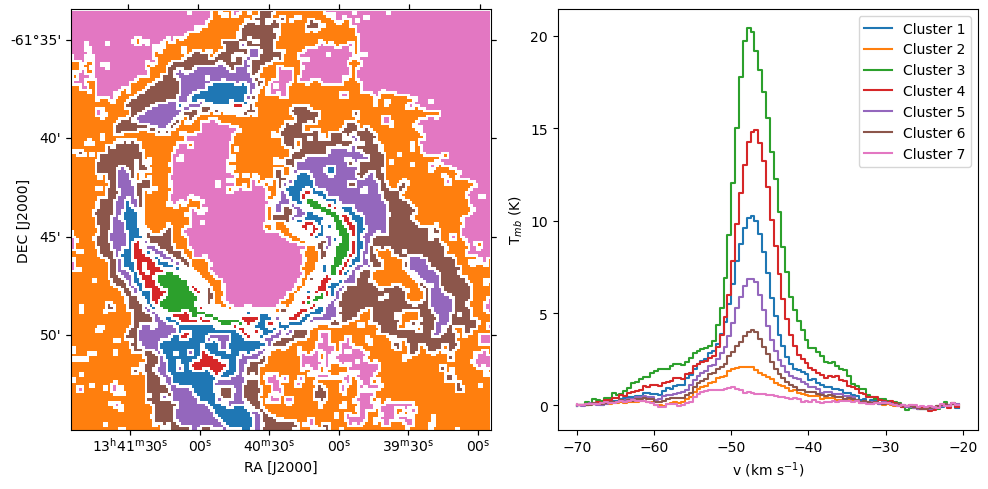

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


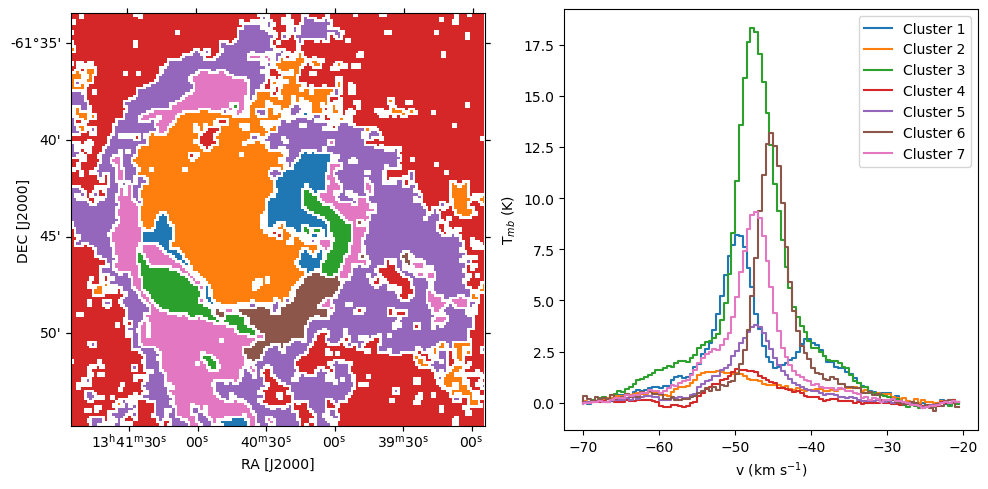

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


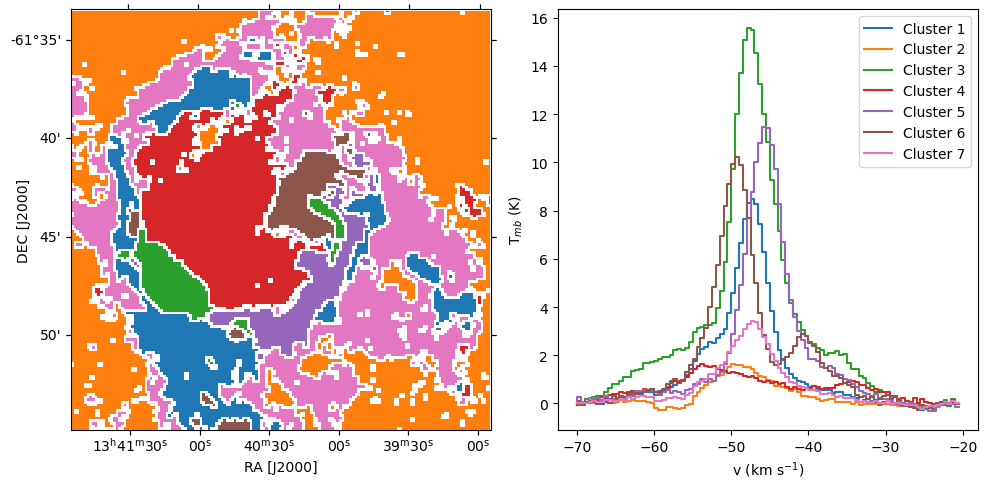

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


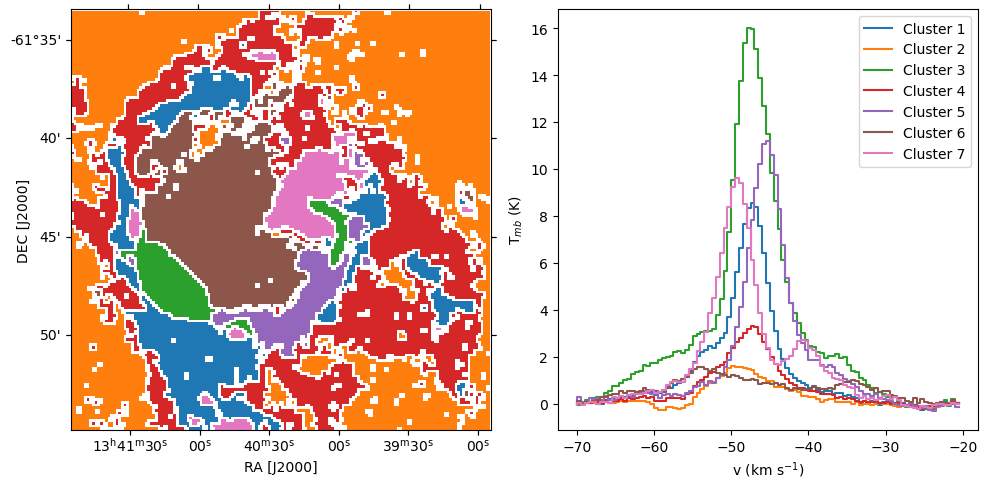

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


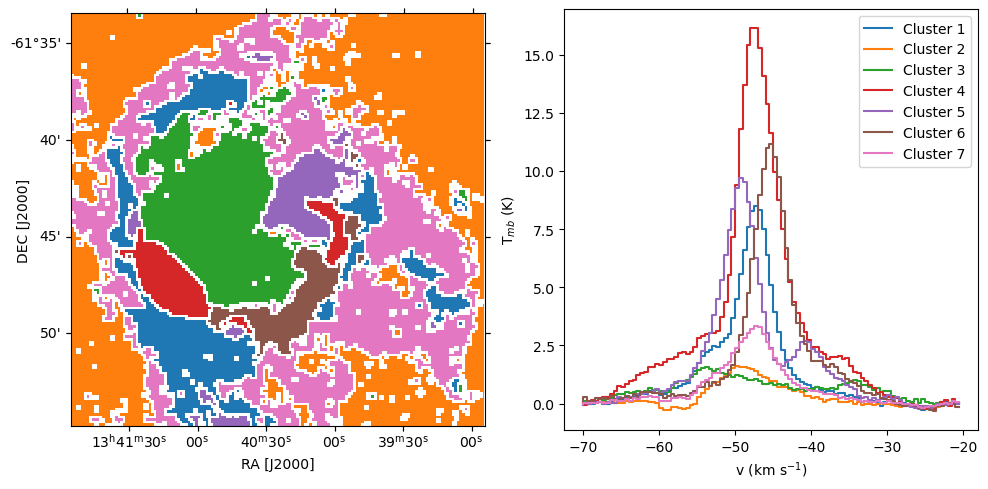

In [6]:
## loop over the number of PCA components
## Evaluate the output of 7 clusters, does it resemble the output for the full data set?
for num_pca in num_pca_comps:
    ## get the pca values along the given axes
    pca_vals, index_arr = get_pca_vals(num_pca, data_cut)
    
    ## fit the GMM
    cluster_inds = GaussianMixture(n_components = orig_n_comps, 
                                 init_params = 'kmeans',
                                 covariance_type = 'full', 
                                 random_state = seed_val,
                                 tol = threshold, 
                                 max_iter = gmm_iter).fit_predict(pca_vals)
    
    ## Map the spatial distribution of the different clusters
    cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_arr, data_cut.shape[2], data_cut.shape[1])
    
    ## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
    pGMM.plot_clusters_and_spectra(data_cut, cluster_map, vel_arr, w)

In [7]:
## Loop over the number of included pca components to see if PCA indeed strongly reduces the GMM fitting time
for num_pca in num_pca_comps:
    print("Performing the GMM analysis for {num} PCA components".format(num = num_pca))
    
    ## get the pca values along the given axes
    pca_vals, index_arr = get_pca_vals(num_pca, data_cut)
    
    ## pass the PCA values to the GMM to fit
    (n_comp_list, bic_list, time_list, best_model, norm_lower_bound_list) = fGMM.fit_GMM(pca_vals, n_comps_min, n_comps_max, print_time = True)
    
    print('\n')
    print(best_model)
    print('\n')

Performing the GMM analysis for 1 PCA components
Calculating GMM for 1 components


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 25600) + inhomogeneous part.

#### Note:
On a dataset like RCW 79, the PCA does not take a lot of time (always < 0.5 seconds)